# Train your First Computer Vision Model in TensorFlow

## Image Recognition of Sign Language for Digits

In this Tensorflow model we will train the model to recognize the digits sign language digits 0 to 5 from a dataset of images (photos) of hand gestures for the corresponding sign language digits.

## Import Math Libraries

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
# iPython command to automatic render plots (do not need to do plt.show())
%matplotlib inline 

## Import Library for Reading Dataset as HDF5 filesystem

The h5py package is a Pythonic interface to the HDF5 binary data format. It lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.

In [2]:
import h5py

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import TensorFlow Libraries

In [3]:
import tensorflow as tf
from tensorflow.python.framework import ops

##### Input Data

The image data for training and test is stored in two HDF5 files. They represent samples of hand gestures for the sign language digits 0 through 5. As you can see, they are somewhat large (total of 14MB).

Directory of C:\Users\User\Desktop\tfnw-2-1\datasets

1,477,712<sp> <i>test_signs.h5</i><br/>
    13,281,872 <i>train_signs.h5</i><br/>
2 File(s)     14,759,584 bytes
    
Let's look at a sample of images. Since we will be training for 6 digits, our output classifier will need to be 6 classes, which we represent as a vector of six elements. The first entry in our classes vector corresponds to the digit zero, the second entry the digit one, and so forth. A match (i.e., label or prediction) for a digit has a one in the corresponding entry, while the other columns are zero.

<img src='images/hands.png'>


## Input Data

Our data are color (RGB) images of hand signs for the digits 0 through 5. Each image is a 64 x 64 x 3. That is, the image consists of three color planes (Red, Green and Blue) with each plane having a pixel width and height of 64 x 64.

There are 1200 images which have been pre-split into training and test data, with 90% of the images as training data and 10% of the images as test data.

Training Images: 1080<br/>
Test Images: 120

## Input Vector

Since we are just building a simple neurel network (not a CNN), the number of input features will equal the size of the pixel data for an image. That is, we will feed all the pixels of an image into the NN as input features.

The input vector will be 64 x 64 x 3 = 12288

YES, that will be a very big input vector and will affect the training time.

## Reading in the Data

The next step is to read the data from the file source. Our images are encoded in a HDF5 filesystem format. The load_dataset() routine below (from Cousera) extracts the image data from the HDF5 file encoding. The image data is encoded as a binary encoding with a dictionary indexing. As you can see from the code, we extract the data using an associative array (dictionary) syntax.

This function will extract the pixel data (X) for the training and test data and the corresponding classification/label (Y) for each image. 

In [6]:
def load_dataset():
    # Extract the training data as Numpy array from the training data file
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) # the features (all rows/all columns)
    train_y = np.array(train_dataset["train_set_y"][:]) # the labels (call rows/all columns)

    # Extract the test data as Numpy array from the training data file
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) # the features (all rows/all columns)
    test_y = np.array(test_dataset["test_set_y"][:]) # the labels (call rows/all columns)

    # Extract the list of classes to predict
    classes = np.array(test_dataset["list_classes"][:]) 
    
    # Reshape the label data into a 1 dimensional array
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y  = test_y.reshape ((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

### Preparing to Load the Image Data

Let's verify we are in the correct folder before loading the data (tfnw-2-1)

In [4]:
pwd()

'C:\\Users\\User\\Desktop\\Desktop\\job\\Portland-Data-Science-Group\\Presentations\\CodeAlong\\tfnw-2-1'

### Load the Data

Let's read in the data now and verify the shape of the data.

In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


Let's look at a sample image in our training set. In this example, we will show (plot) the 6th image (index 5).

y = 4


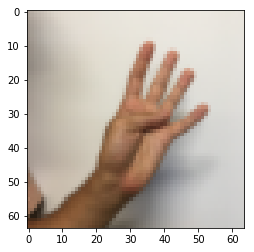

In [8]:
# Example of a picture
index = 5
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train_orig[0][index]))

### Flatten and Normalize the Image Data

Now we will flatten the data (reshape so all rows follow each other sequential in a single vector) and normalize the pixel values between 0 and 1.

In [9]:
# Flatten the Image Data
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize the Pixel Values between 0 and 1
X_train = X_train_flatten / 255.0
X_test = X_test_flatten / 255.0

Let's verify the shape of our flatten input vectors, We should see 12288 in the first dimension, corresponding to the number of pixels in each image (64 x 64 x 3).

In [10]:
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (12288, 1080)
X_test shape: (12288, 120)


### Categorical Conversion of Classes

Let's now convert the labels to a one hot encoding.

In [11]:
# Let's look at the current shape and contents of our label data
Y_test_orig

array([[0, 0, 0, 5, 1, 0, 3, 1, 5, 1, 5, 1, 3, 1, 1, 3, 5, 4, 0, 4, 5, 4,
        2, 5, 3, 5, 4, 2, 1, 2, 3, 1, 0, 3, 1, 1, 0, 4, 2, 3, 0, 3, 0, 2,
        3, 1, 2, 2, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 4, 4, 5, 5, 2, 4, 4, 5,
        0, 1, 3, 5, 0, 4, 1, 2, 3, 4, 3, 5, 1, 5, 2, 0, 1, 4, 2, 4, 4, 1,
        4, 5, 5, 0, 0, 5, 5, 5, 3, 3, 5, 2, 2, 2, 0, 2, 5, 3, 0, 2, 3, 4,
        1, 3, 2, 4, 2, 2, 1, 3, 1, 3]], dtype=int64)

In [12]:
def convert_labels_to_one_hot_encoding(Y, C):
    """ This function will do the reshape and conversion (from Coursera)"""
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Let's do the conversion
Y_train = convert_labels_to_one_hot_encoding(Y_train_orig, 6)
Y_test  = convert_labels_to_one_hot_encoding(Y_test_orig, 6)

In [13]:
# Let's look at the shape / contents after the conversion
Y_test

array([[1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [14]:
Y_test

array([[1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

## Building your first neural network in TensorFlow

### Design, then Run

#### Design

     -- Create placeholders for your input data
     -- Design the layers as a Graph
     -- Set the optimizer
     
#### Run

      -- Initialize the Graph
      -- Set number of epochs
      -- Set batch size, learning rate
      -- Run the Graph with the Training Data to Train a Model
      -- Validate the Model with Test Data


## Input Vector Placeholder

For our first tensorflow step, we will setup a TF placeholder for the input vector.

We have two placeholders we need to declare, one for the input vector (pixel image data) and one for the output vector (digit classifier).

For our input placeholder (which we call X), we have 12,288 features (pixels per image). For the output vector (which we call Y), we have have 6 classifiers (0 .. 5 digits). In both cases, we set the second dimension of our vector to None. The None is
a placeholder for the number of samples we will feed into the neural network.

In [17]:
# Let's first reset our graph, so our neural network components are all declared within the same graph
ops.reset_default_graph() 

In [16]:
X = tf.placeholder(tf.float32, shape=[12288, None], name='X')
Y = tf.placeholder(tf.float32, shape=[6, None], name='Y')

## Design of our Neural Network

We will design our neural network to have an input layer, an output layer, and one hidden layer. The signal (activation function) from the input layer and hidden layers will be a linear rectifier unit (RELU) and the signal (activation function) from the output layer will be a sigmoid.

Below is a depiction of what will be the forward feed process through the neural network we will construct:

INPUT LAYER => RELU => HIDDEN LAYER => RELU => OUTPUT LAYER => SOFTMAX

## INPUT LAYER

The input layer will have 12288 inputs (pixels) and 25 outputs. Each input will need a weight (which we will train). Each output will need a bias (which we will train) and be passed through the linear rectifier unit (RELU) activation function.

We will initialize the weights using a random value initializer (Xavier) and initialize the biases to zero.

In [19]:
tf.set_random_seed(1)   # Set the same seed to get the same initialization as in this demo.

W1 = tf.get_variable("W1", [25, 12288], initializer=tf.contrib.layers.xavier_initializer(seed=1))
b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())

Let's construct the input layer. 

- Create a node that will multiply the weights (W1) against the input vector (X - which is our input placeholder).
- Create a node that adds the bias to the above node (W1 * X)
- Pass the outputs from the input layer through a RELU activation function


In [18]:
# The first layer
Z1 = tf.add(tf.matmul(W1, X), b1)

# Let's add the activation function to the output signal from the first layer
A1 = tf.nn.relu(Z1)

NameError: name 'W1' is not defined

In [15]:
# Let's verify that there are 25 outputs from the RELU corresponding to the 25 outputs from the first layer
A1

<tf.Tensor 'Relu:0' shape=(25, ?) dtype=float32>

## (FIRST) HIDDEN LAYER

The (first) hidden layer will have 25 inputs (outputs from input layer) and 12 outputs. Each input will need a weight and a bias (which we will train). Each output will be passed through the linear rectifier unit (RELU) activation function.

We will initialize the weights using a random value initializer (Xavier) and initialize the biases to zero.



In [16]:
W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed=1))
b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())

Let's construct the (first) hidden layer

- Create a node that will multiply the weights (W2) against the outputs of the input layer (A1).
- Create a node that adds the bias to the above node (W2 * A1)
- Pass the outputs from the (first) hidden layer through a RELU activation function

In [17]:
Z2 = tf.add(tf.matmul(W2, A1), b2)                              
A2 = tf.nn.relu(Z2)

## OUTPUT LAYER

The second hidden layer will have 12 inputs (outputs from first hidden layer) and 6 outputs (one for each class). Each input will need a weight and a bias (which we will train). The 6 outputs will be passed through a sigmoid activation function. 

We will initialize the weights using a random value initializer (Xavier) and initialize the biases to zero.



In [18]:
W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())

Let's construct the output layer

- Create a node that will multiply the weights (W3) against the outputs of the hidden layer (A2).
- Create a node that adds the bias to the above node (W3 * A2)
- Pass the outputs from the output layer through a SOFTMAX squashing function

In [19]:
Z3 = tf.add(tf.matmul(W3, A2), b3) 

## OPTIMIZER

Now its time to design our optimizer. Let's start by designing our cost function (from Coursera). We will use the mean value of the softmax cross entropy between the predicted labels and actual labels. This is what we want to reduce on each batch.

In [20]:
def compute_cost(Yhat, Y):
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Yhat) # Predicted Labels
    labels = tf.transpose(Y)    # Actual Labels
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                 labels=labels))
    
    return cost

cost = compute_cost(Z3, Y)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Let's now design the optimizer. We will use the Adam Optimizer to adjust (train) weights in our neural network to minimize our cost.

To control the rate of gradient descent and achieve convergence at/near a global optima, we set a learning rate as well.


In [21]:
def optimize(lr, cost):
    return tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

learning_rate = 0.0001
optimizer = optimize(learning_rate, cost)

## Run the Neural Network

First we need a function to build mini batches from our training set. We want each batch to be a random selection. We will use
this function below (from Coursera)

In [22]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

We have a little housekeeping (setup) to do. 
- Let's tensorflow we prefer to use a GPU if one is available.
- Set a seed for generating random values
- Initialize the global tensorflow variables

In [23]:
# Some initial housekeeping
#device = '/gpu:0'
device = '/cpu:0'
with tf.device( device ):
    tf.set_random_seed(1)                             # to keep consistent results 
    init = tf.global_variables_initializer()          # Initialize all the variables    

Let's now set some more hyperparameters:
- The number of epochs to run
- Number of samples in the training data
- The mini-batch size


In [27]:
num_epochs     = 1500                 # Number of epochs to run
nsamples       = X_train[0].shape[0]  # Number of samples in training set
minibatch_size = 32                   # The mini-batch size (32, 64, 128, ...)
costs          = []                   # List to track cost across epochs

## Run the Graph

Let's run the graph now.
- Setup a tensorflow session
- Issue a run() for initializing our variables
- Run our training data 1500 times (epochs) through our neural network
    - For each epoch, split the training data into mini-batch sizes of 32
    - Run() the node optimizer which will feed the mini-batch through the neural network and calculate the cost and update
      the weights at the end of the mini-batch (not after each sample).
    - Maintain an accumulated cost of the mini-batches for the epoch 

In [33]:
start = time.time()

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        
        # Run the initialization
        sess.run(init)
        
        seed = 3   # Set an initial seed so you get the same results as the demo
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(nsamples / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", 
                # the fee_dict should contain a minibatch for (X,Y).
                
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                             feed_dict={X: minibatch_X, 
                                                        Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
            
        end = time.time()
        print("\nTotal Time to Train: ", end - start)
    
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572938
Cost after epoch 400: 0.468799
Cost after epoch 500: 0.380979
Cost after epoch 600: 0.313819
Cost after epoch 700: 0.254258
Cost after epoch 800: 0.203795
Cost after epoch 900: 0.166410
Cost after epoch 1000: 0.141497
Cost after epoch 1100: 0.107579
Cost after epoch 1200: 0.086229
Cost after epoch 1300: 0.059415
Cost after epoch 1400: 0.052237
Total Time to Train:  543.956511259079
Train Accuracy: 0.9990741
Test Accuracy: 0.71666664


### PLOT the COST vs. EPOCHS

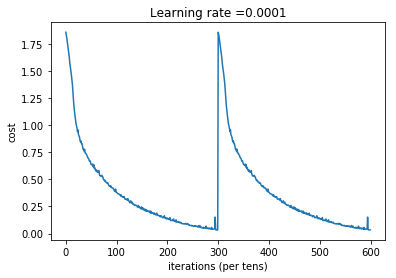

In [34]:
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

# CONGRATULATIONS - You Successfully Ran a TensorFlow Neural Network